# 1. Preparação do notebook

In [1]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 10.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from google.colab import files
from scipy.stats import mstats                                      # para winsorização
from statsmodels.nonparametric.kernel_regression import KernelReg   # para suavização por kernel
from statsmodels.tsa.holtwinters import SimpleExpSmoothing          # para suavização exponencial simples
from statsmodels.tsa.holtwinters import Holt                        # para suavização exponencial quadrática
from scipy.interpolate import UnivariateSpline                      # para smoothing splines
from statsmodels.nonparametric.smoothers_lowess import lowess       # para lowess smoothing
from statsmodels.tsa.filters.hp_filter import hpfilter              # para filtro hidrick-prescott
from pykalman import KalmanFilter                                   # para filtro de kalman
import warnings
import matplotlib.pyplot as plt

In [3]:
# Oculta avisos específicos do NumPy
warnings.filterwarnings("ignore", category=UserWarning, module="numpy")

# 2. Leitura dos dados

In [4]:
# Abertura da caixa de diálogo para selecionar o arquivo
uploaded = files.upload()

# Obtenção do nome do arquivo selecionado
filename = list(uploaded.keys())[0]

# Leitura do arquivo para um DataFrame
df = pd.read_excel(filename)

df.head()

Saving [BM Heterocedasticity] Geração de séries temporais.xlsx to [BM Heterocedasticity] Geração de séries temporais.xlsx


,bm_heteroscedasticity_1,bm_heteroscedasticity_2,bm_heteroscedasticity_3,bm_heteroscedasticity_4,bm_heteroscedasticity_5,bm_heteroscedasticity_6,bm_heteroscedasticity_7,bm_heteroscedasticity_8,bm_heteroscedasticity_9,bm_heteroscedasticity_10
0,0.496714,-1.544434,-0.120643,-0.160665,0.269824,-1.153504,-1.239162,1.178275,-2.678408,-0.496440
1,0.358357,-1.051218,-0.470764,-1.545975,0.577584,-302.123778,-0.102988,0.852262,-1.671607,0.696883
2,1.006917,-0.216493,-0.651815,273.603212,-0.181961,0.326851,0.237425,191.234731,-1.406661,0.361209
3,2.533023,-0.818833,-1.367922,-1.852257,0.878579,0.386145,-0.179616,190.550507,-1.583443,-0.212217
4,2.298239,0.350223,-1.728802,-3.088030,0.435163,-1.599820,-1.725778,0.879891,-3.254722,0.069842


In [5]:
df = df[['bm_heteroscedasticity_1']]
df.head()

,bm_heteroscedasticity_1
0,0.496714
1,0.358357
2,1.006917
3,2.533023
4,2.298239


# 3. Aplicação dos métodos de tratamento

In [6]:
# Winsorização
def winsorize_series(series, limits=[0.05, 0.05]):
    series = series.copy()  # Evita alterar a série original
    series_filled = series.fillna(series.median())  # Substituir NaN pela mediana

    winsorized_values = mstats.winsorize(series_filled, limits=limits)

    return pd.Series(winsorized_values, index=series.index)

# Médias Móveis
def moving_average(series, window=5):
    return series.rolling(window=window).mean()

# Suavização por Kernel
def kernel_smoothing(series, bandwidth=1):
    series = series.dropna()  # Remover valores ausentes
    x = np.arange(len(series))
    kr = KernelReg(series, x, 'c', reg_type='ll', bw=[bandwidth])

    smoothed_values = kr.fit()[0]  # Ajuste do Kernel
    return pd.Series(smoothed_values, index=series.index)

# Suavização Exponencial Simples
def simple_exponential_smoothing(series, alpha=0.3):
    series = series.fillna(method="ffill")  # Preenchendo valores ausentes

    model = SimpleExpSmoothing(series)
    fit = model.fit(smoothing_level=alpha, optimized=False)

    return pd.Series(fit.fittedvalues, index=series.index)

# Suavuzação Exponencial Quadrática
def holts_linear_trend(series, alpha=0.3, beta=0.1):
    series = series.fillna(method="ffill")  # Preenchendo valores ausentes

    model = Holt(series)
    fit = model.fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)

    return pd.Series(fit.fittedvalues, index=series.index)

# Smoothing Splines
def smoothing_splines(series, s=0.1):
    series = series.dropna()  # Remover valores NaN antes de processar

    # Criar um spline apenas para os valores não nulos
    x = np.arange(len(series))
    y = series.values
    spl = UnivariateSpline(x, y, s=s)

    # Preencher os valores suavizados
    smoothed_values = spl(x)

    # Retornar uma série no formato original (preservando índices)
    return pd.Series(smoothed_values, index=series.index)

# Lowess Smoothing
def lowess_smoothing(series, frac=0.1):
    series = series.dropna()  # Remover valores NaN antes de processar

    x = np.arange(len(series))
    smoothed = lowess(series, x, frac=frac, return_sorted=False)

    # Retornar como pandas Series mantendo o mesmo índice original
    return pd.Series(smoothed, index=series.index)

# Filtro Recursivo
def recursive_filter(series, alpha=0.3):
    series = series.fillna(method="ffill")  # Preenchendo valores ausentes

    result = [series.iloc[0]]
    for i in range(1, len(series)):
        result.append(alpha * series.iloc[i] + (1 - alpha) * result[i-1])

    return pd.Series(result, index=series.index)

# Filtro Hodick-Prescott
def hodrick_prescott_filter(series, lamb=13322500):
    series = series.dropna()  # Remover valores ausentes

    cycle, trend = hpfilter(series, lamb=lamb)
    return pd.Series(trend, index=series.index)

# Filtro de Kalman
def kalman_filter(series):
    series = series.fillna(method="ffill")  # Preenchendo valores ausentes

    kf = KalmanFilter(initial_state_mean=series.iloc[0], n_dim_obs=1)
    filtered_state_means, _ = kf.filter(series.values)

    return pd.Series(filtered_state_means.flatten(), index=series.index)

## 3.1. Divisão das séries em conjunto de treino (70%) e de teste (30%)

In [7]:
# Definindo o índice de corte (80% para treino)
train_size = int(len(df) * 0.7)

# Separando treino e teste
df_train = df.iloc[:train_size, :]
df_test = df.iloc[train_size:, :]

df_train.head()

,bm_heteroscedasticity_1
0,0.496714
1,0.358357
2,1.006917
3,2.533023
4,2.298239


In [8]:
# Tamanho do conjunto de treino
n = len(df_train)
n

4160

In [9]:
df.columns

Index(['bm_heteroscedasticity_1'], dtype='object')

In [10]:
################################
##### Detecção de outliers #####
################################

# Função para calcular o percentual de outliers usando o método IQR
def calcular_percentual_outliers(series):
    q1 = np.percentile(series, 25)
    q3 = np.percentile(series, 75)
    iqr = q3 - q1
    lim_inf = q1 - 1.5 * iqr
    lim_sup = q3 + 1.5 * iqr
    outliers = (series < lim_inf) | (series > lim_sup)
    return np.mean(outliers) * 100

# Calcular o percentual de outliers para cada série
percentuais_outliers = calcular_percentual_outliers(df_train)
print(f"Porcentagem de outliers: {percentuais_outliers:.2f}%")

Porcentagem de outliers: 2.96%


## 3.2. Aplicação dos métodos de tratamento de outliers

In [11]:
methods = {
    'W': winsorize_series,
    'MA': moving_average,
    'KS': kernel_smoothing,
    'SES': simple_exponential_smoothing,
    'QES': holts_linear_trend,
    'SPLINES': smoothing_splines,
    'LOWESS': lowess_smoothing,
    'RF': recursive_filter,
    'HP': hodrick_prescott_filter,
    'KALMAN': kalman_filter
}

# Criar um DataFrame para armazenar os resultados
df_processed = pd.DataFrame(index=df_train.index)

# Definir a coluna específica que será processada
coluna_alvo = coluna_alvo = df_train.columns[0]

# Aplicação dos métodos e adicionando ao DataFrame processado
for method_name, method_func in methods.items():
    df_processed[f'{coluna_alvo}_{method_name}'] = method_func(df_train[coluna_alvo])

# Resetar o índice para incluir a coluna 'Date' novamente
df_processed = df_processed.reset_index()

df_processed.head()

<ipython-input-6-e03f29328a2c>:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method="ffill")  # Preenchendo valores ausentes
<ipython-input-6-e03f29328a2c>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method="ffill")  # Preenchendo valores ausentes
<ipython-input-6-e03f29328a2c>:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method="ffill")  # Preenchendo valores ausentes
<ipython-input-6-e03f29328a2c>:85: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method="ffill")  # Preenchendo valores ausentes


,index,bm_heteroscedasticity_1_W,bm_heteroscedasticity_1_MA,bm_heteroscedasticity_1_KS,bm_heteroscedasticity_1_SES,bm_heteroscedasticity_1_QES,bm_heteroscedasticity_1_SPLINES,bm_heteroscedasticity_1_LOWESS,bm_heteroscedasticity_1_RF,bm_heteroscedasticity_1_HP,bm_heteroscedasticity_1_KALMAN
0,0,0.496714,NaN,0.421277,0.496714,0.358357,0.496722,-8.999386,0.496714,-4.471631,0.496714
1,1,0.358357,NaN,0.633406,0.496714,0.265657,0.358291,-8.985618,0.455207,-4.518343,0.413700
2,2,1.006917,NaN,1.257028,0.455207,0.162041,1.007218,-8.971718,0.620720,-4.565055,0.778757
3,3,2.533023,NaN,1.959971,0.620720,0.309425,2.532281,-8.957685,1.194411,-4.611765,1.862274
4,4,2.298239,1.33865,2.302196,1.194411,0.937133,2.299242,-8.943520,1.525559,-4.658473,2.131691


In [12]:
df_processed.tail()

,index,bm_heteroscedasticity_1_W,bm_heteroscedasticity_1_MA,bm_heteroscedasticity_1_KS,bm_heteroscedasticity_1_SES,bm_heteroscedasticity_1_QES,bm_heteroscedasticity_1_SPLINES,bm_heteroscedasticity_1_LOWESS,bm_heteroscedasticity_1_RF,bm_heteroscedasticity_1_HP,bm_heteroscedasticity_1_KALMAN
4155,4155,105.338456,104.811278,105.862539,108.780090,108.340421,105.338496,91.381285,107.747600,95.459272,105.250681
4156,4156,107.338090,105.296461,106.080772,107.747600,106.120511,107.338062,91.288092,107.624747,95.507816,106.540771
4157,4157,105.524701,105.353607,105.222893,107.624747,105.202992,105.524714,91.195013,106.994733,95.556364,105.912805
4158,4158,103.055971,105.484025,103.869836,106.994733,104.026363,103.055966,91.102048,105.813104,95.604913,104.147184
4159,4159,103.375787,104.926601,103.156891,105.813104,102.432992,103.375788,91.009197,105.081909,95.653463,103.670435


##3.3. Cálculo do % de outliers remanescentes

In [13]:
# Definição das colunas
colunas = df_processed.columns.tolist()

# Dicionário para armazenar as porcentagens de outliers
percentage_dict = {}

# Detectando outliers
for col in colunas:
    percentage_dict[col] = calcular_percentual_outliers(df_processed[col])

# Exibindo os resultados
for col in colunas:
    print(f"Porcentagem de outliers em {col}: {percentage_dict[col]:.2f}%")

Porcentagem de outliers em index: 0.00%
Porcentagem de outliers em bm_heteroscedasticity_1_W: 0.00%
Porcentagem de outliers em bm_heteroscedasticity_1_MA: 0.00%
Porcentagem de outliers em bm_heteroscedasticity_1_KS: 0.31%
Porcentagem de outliers em bm_heteroscedasticity_1_SES: 0.00%
Porcentagem de outliers em bm_heteroscedasticity_1_QES: 0.02%
Porcentagem de outliers em bm_heteroscedasticity_1_SPLINES: 2.96%
Porcentagem de outliers em bm_heteroscedasticity_1_LOWESS: 0.00%
Porcentagem de outliers em bm_heteroscedasticity_1_RF: 0.00%
Porcentagem de outliers em bm_heteroscedasticity_1_HP: 0.00%
Porcentagem de outliers em bm_heteroscedasticity_1_KALMAN: 1.03%


#4. Análise gráfica

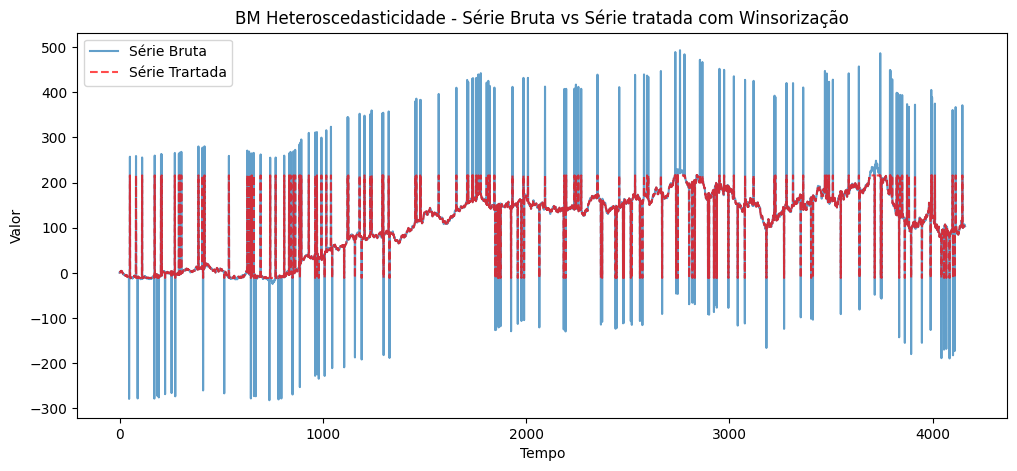

In [14]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['bm_heteroscedasticity_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['bm_heteroscedasticity_1_W'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Heteroscedasticidade - Série Bruta vs Série tratada com Winsorização")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

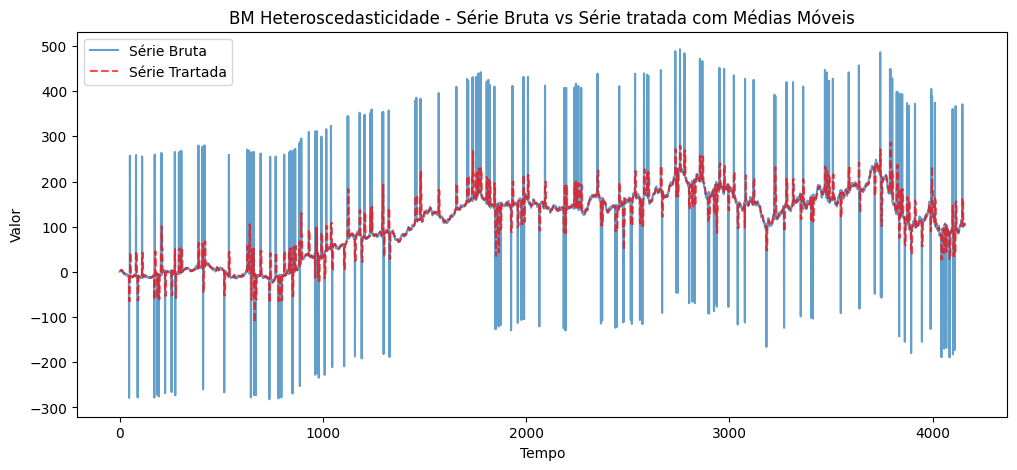

In [15]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['bm_heteroscedasticity_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['bm_heteroscedasticity_1_MA'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Heteroscedasticidade - Série Bruta vs Série tratada com Médias Móveis")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

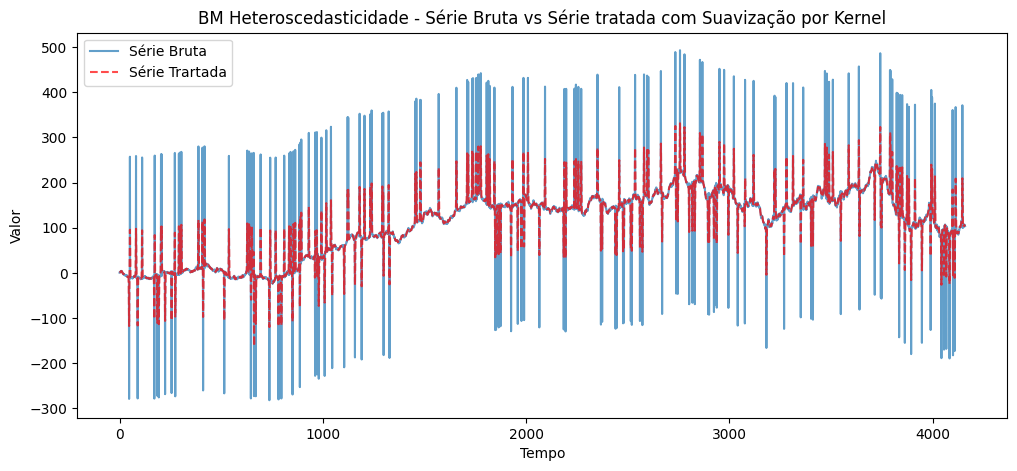

In [16]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['bm_heteroscedasticity_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['bm_heteroscedasticity_1_KS'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Heteroscedasticidade - Série Bruta vs Série tratada com Suavização por Kernel")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

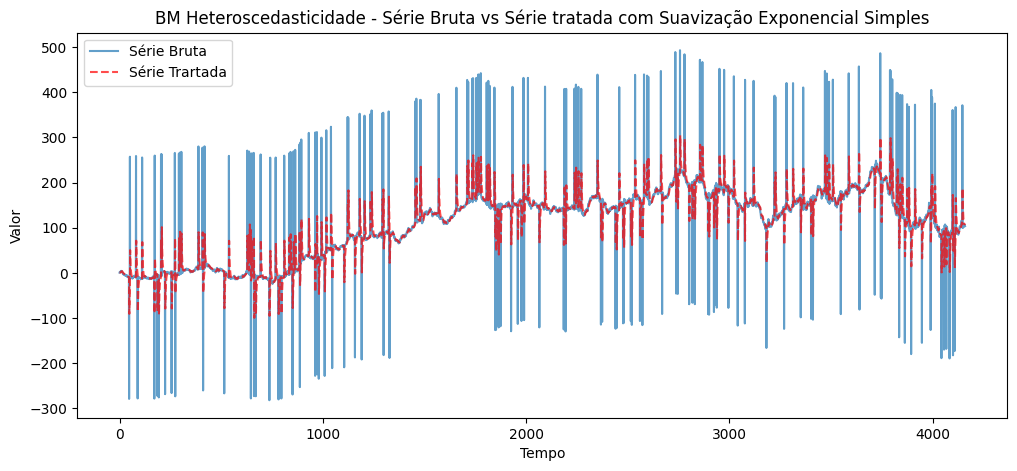

In [17]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['bm_heteroscedasticity_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['bm_heteroscedasticity_1_SES'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Heteroscedasticidade - Série Bruta vs Série tratada com Suavização Exponencial Simples")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

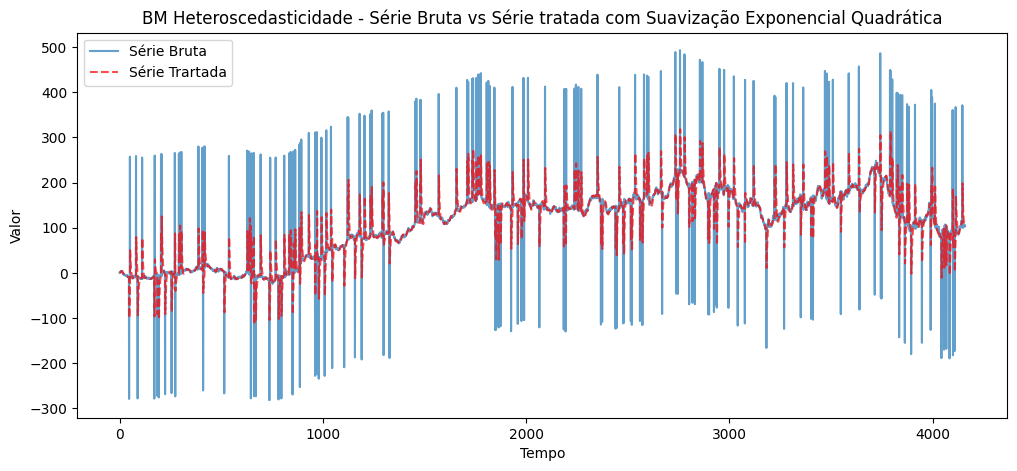

In [18]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['bm_heteroscedasticity_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['bm_heteroscedasticity_1_QES'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Heteroscedasticidade - Série Bruta vs Série tratada com Suavização Exponencial Quadrática")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

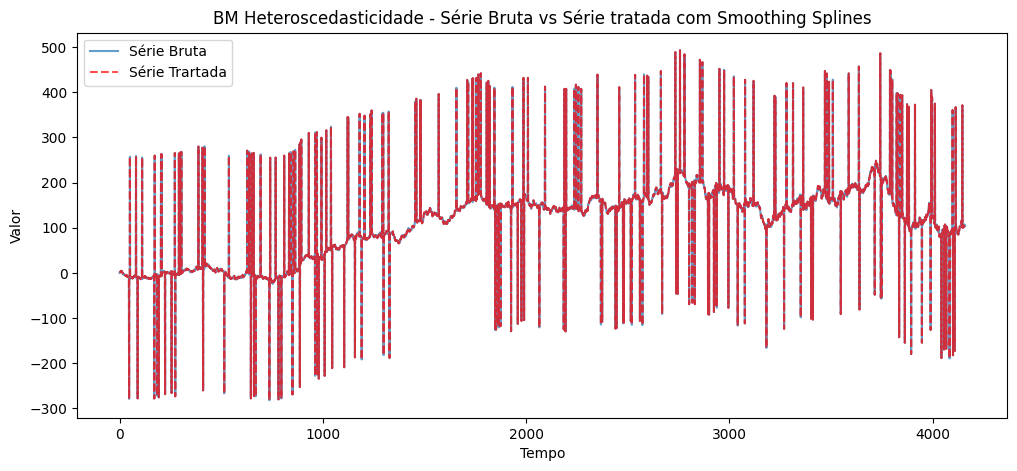

In [19]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['bm_heteroscedasticity_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['bm_heteroscedasticity_1_SPLINES'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Heteroscedasticidade - Série Bruta vs Série tratada com Smoothing Splines")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

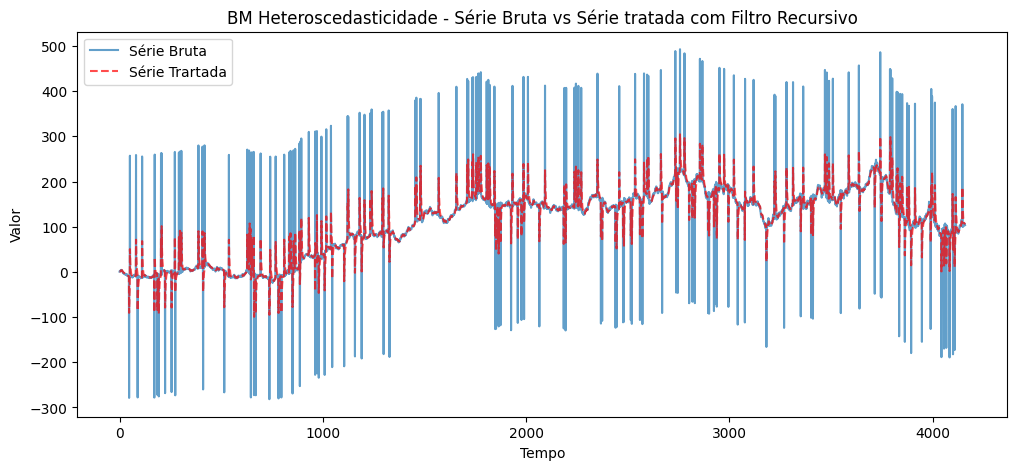

In [20]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['bm_heteroscedasticity_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['bm_heteroscedasticity_1_RF'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Heteroscedasticidade - Série Bruta vs Série tratada com Filtro Recursivo")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

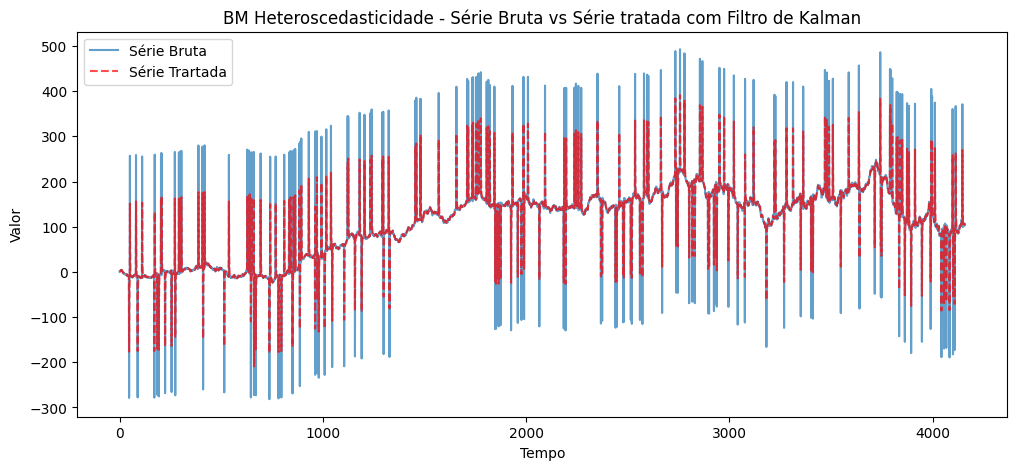

In [21]:
# Comparação entre as séries geradas (séries brutas vs séries tratadas)
plt.figure(figsize=(12, 5))
plt.plot(df_train['bm_heteroscedasticity_1'], label='Série Bruta', alpha=0.7)
plt.plot(df_processed['bm_heteroscedasticity_1_KALMAN'], label='Série Trartada', alpha=0.7, linestyle='dashed', color='red')
plt.legend()
plt.title("BM Heteroscedasticidade - Série Bruta vs Série tratada com Filtro de Kalman")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

# 5. Concatenação conjuntos de treino com conjuntos e teste

In [22]:
df_final = pd.DataFrame()
df_final['bm_heteroscedasticity_1_W'] = pd.concat([df_processed['bm_heteroscedasticity_1_W'], df_test['bm_heteroscedasticity_1']], axis=0).to_frame(name="BM_W")
df_final['bm_heteroscedasticity_1_MA'] = pd.concat([df_processed['bm_heteroscedasticity_1_MA'], df_test['bm_heteroscedasticity_1']], axis=0).to_frame(name="BM_MA")
df_final['bm_heteroscedasticity_1_KS'] = pd.concat([df_processed['bm_heteroscedasticity_1_KS'], df_test['bm_heteroscedasticity_1']], axis=0).to_frame(name="BM_KS")
df_final['bm_heteroscedasticity_1_SES'] = pd.concat([df_processed['bm_heteroscedasticity_1_SES'], df_test['bm_heteroscedasticity_1']], axis=0).to_frame(name="BM_SES")
df_final['bm_heteroscedasticity_1_QES'] = pd.concat([df_processed['bm_heteroscedasticity_1_QES'], df_test['bm_heteroscedasticity_1']], axis=0).to_frame(name="BM_QES")
df_final['bm_heteroscedasticity_1_SPLINES'] = pd.concat([df_processed['bm_heteroscedasticity_1_SPLINES'], df_test['bm_heteroscedasticity_1']], axis=0).to_frame(name="BM_SPLINES")
df_final['bm_heteroscedasticity_1_LOWESS'] = pd.concat([df_processed['bm_heteroscedasticity_1_LOWESS'], df_test['bm_heteroscedasticity_1']], axis=0).to_frame(name="BM_LOWESS")
df_final['bm_heteroscedasticity_1_RF'] = pd.concat([df_processed['bm_heteroscedasticity_1_RF'], df_test['bm_heteroscedasticity_1']], axis=0).to_frame(name="BM_RF")
df_final['bm_heteroscedasticity_1_HP'] = pd.concat([df_processed['bm_heteroscedasticity_1_HP'], df_test['bm_heteroscedasticity_1']], axis=0).to_frame(name="BM_HP")
df_final['bm_heteroscedasticity_1_KALMAN'] = pd.concat([df_processed['bm_heteroscedasticity_1_KALMAN'], df_test['bm_heteroscedasticity_1']], axis=0).to_frame(name="BM_KALMAN")
df_final

,bm_heteroscedasticity_1_W,bm_heteroscedasticity_1_MA,bm_heteroscedasticity_1_KS,bm_heteroscedasticity_1_SES,bm_heteroscedasticity_1_QES,bm_heteroscedasticity_1_SPLINES,bm_heteroscedasticity_1_LOWESS,bm_heteroscedasticity_1_RF,bm_heteroscedasticity_1_HP,bm_heteroscedasticity_1_KALMAN
0,0.496714,NaN,0.421277,0.496714,0.358357,0.496722,-8.999386,0.496714,-4.471631,0.496714
1,0.358357,NaN,0.633406,0.496714,0.265657,0.358291,-8.985618,0.455207,-4.518343,0.413700
2,1.006917,NaN,1.257028,0.455207,0.162041,1.007218,-8.971718,0.620720,-4.565055,0.778757
3,2.533023,NaN,1.959971,0.620720,0.309425,2.532281,-8.957685,1.194411,-4.611765,1.862274
4,2.298239,1.338650,2.302196,1.194411,0.937133,2.299242,-8.943520,1.525559,-4.658473,2.131691
...,...,...,...,...,...,...,...,...,...,...
5938,-349.127908,-349.127908,-349.127908,-349.127908,-349.127908,-349.127908,-349.127908,-349.127908,-349.127908,-349.127908
5939,-337.974920,-337.974920,-337.974920,-337.974920,-337.974920,-337.974920,-337.974920,-337.974920,-337.974920,-337.974920
5940,-344.577533,-344.577533,-344.577533,-344.577533,-344.577533,-344.577533,-344.577533,-344.577533,-344.577533,-344.577533
5941,-340.721043,-340.721043,-340.721043,-340.721043,-340.721043,-340.721043,-340.721043,-340.721043,-340.721043,-340.721043


# 6. Exportação do dataframe

In [23]:
file_path = '[BM Heteroscedasticity 1] Séries temporais.xlsx'
df_final.to_excel(file_path, index=False)
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>